# RDBMS - MySQL 

## 00 - Introduction

Among the Relational DBMSs, the most widely known are Oracle, SQLite, Postgress, MariaDB, MySQL.

Each one of them is characterized by a different set of "variations" on top of the base SQL language, although usually minor.

We will use **MySQL** to run exercises about Relational DB transactions using the SQL language, as it is *today* at the top of the list of most widely used RDBs. 

https://db-engines.com/en/ranking_trend/relational+dbms

https://www.statista.com/statistics/809750/worldwide-popularity-ranking-database-management-systems/

https://insights.stackoverflow.com/survey/2021#most-popular-technologies-database

MySQL programming interfaces exist for many languages, including C, C++, Go, Java, Perl, PHP, Python, etc...

Even simply referring to Python, we can count on several options to connect and interact with the DBs. 

Let's explore a couple of them...

## 01 - Create a connection to MySQL 

A MySQL server is in execution on one of your Docker containers.

We can access it via the MySQL server credential we have defined in the docker-compose yml.

A `root` user is created by default with:
- user: `root`
- password: `root_pwd`

A non-`root` user is also created by default with:
- user: `my_user`
- password: `my_pwd`

#### Interactive 

We can interact with the MySQL server by logging in interactively to its docker container.

Check the `CONTAINER ID` of the container named `mysql_db` via:
    
```bash 
$ docker ps 
```

And run `bash` (or `/bin/bash`) in interactive mode attaching it to the terminal (`-it`) on the container:

```bash
$ docker exec -it <YOUR CONTAINER ID> bash
```

From inside the container we can use the RDBMS interface as if we were logged into a remote MySQL server hosting our DBs

```bash
$ mysql -u <EITHER ROOT OR USER> -p
``` 

We can then inspect the MySQL server to show us all DBs:
    
```mysql
SHOW DATABASES;
```

_NB_: remember to end a SQL command with a semicolon `;`

#### mysql.connector

A more pythonic way of communicating with a MySQL server is by using a dedicated driver.

We will use `mysql.connector`, which has already been installed in the Jupyter-notebook container for you.

The connector offers an interface to declare a connection object to the server, and provides a series of functionalities to issue transactions and fetch records from DBs.

We start by declaring a connection to our MySQL server.

_NB_: the server is hosted in a different container from the notebook... we are simulating a connection between two differen machines, a client and a server.

In [1]:
# import the connector
import mysql.connector

# declare a connection to the MySQL server 
# the hostname (or IP) of the server machine should be passed
db = mysql.connector.connect(
  user="root",
  password="root_pwd",
  host="db", # in this case 'db' is the equivalent of the IP address of the server 
             # or 'localhost' if running mysql locally
)

print(db)




At this point a DB connection is enstablished

To interact with the DB via python and mysql.connector we need a "handle", known as a cursor, which has to be instantiated.

Using this connector to interact with the DB, all SQL statements are executed using the cursor.

In [2]:
# create our db cursor object
dbc = db.cursor()

The cursor allows to execute all SQL transactions on the DB as if we were logged into the server.

If a transaction will fetch a result from the DB (a set of records are returned), the connector object will retain the results.

This might come in handy for us to use it in a more "pythonic" way later on, interfacing our DB query with other Python statements.

The syntax for issuing a generic SQL statement is the following:

```python
connector_object.execute(my_sql_query)
```

For instance, let's try to execute the same check as before, by asking MySQL to show us all available DBs...

In [3]:
# show all available databases
dbc.execute(
"SHOW DATABASES"
)

No output is printed as the result of this SQL transaction is in fact "collected" into the cursor as a list of records (tuples).

We can simply loop over them to return the results.

In [4]:
# loop over the container to fetch the results
for _ in dbc:
    print(_)

('IMDb',)
('information_schema',)
('mysql',)
('performance_schema',)
('sys',)


If we are `root` users in this example, we are able to see inner structure of the mysql server, which already contains a few dbs by default. 

Once fetched the output of the transaction, the cursor reaches "the end" of the records, and is available to perform a new transaction

In [5]:
# use fetch to retrieve one, many, or all entries in the cursor
dbc.fetchone()

# dbc.fetchmany(2)

# dbc.fetchall()

In the case one wants to perform a new transaction without collecting the output of the previos one from the cursor, a reset have to be issued first:

```python 
connector_object.reset()
```


In the case a generic user is instead logged into the db (i.e. non the `root` user), it will not have access to a set of functionalities, and will not be able to see the previous list of all databases.

Some of those are in fact protected and used to store additional information on the state of the MySQL server, the users connected, ...

In [6]:
udb = mysql.connector.connect(
  user="my_user",
  password="my_pwd",
  host="db",
)

udbc = udb.cursor()

udbc.execute(
"SHOW DATABASES"
)

udbc.fetchall()

[('information_schema',), ('performance_schema',)]

#### iPython magic

An alternative way to perform queries from Python over a Jupyter-notebook is by using some notebook "magic", based on iPython and SQLAlchemy.

This is a similar thing to what is usually done to load inline a figure from matplotlib (the `%matplotlib inline` thingy).

To instruct iPython to interpret SQL commands, and to connect to the proper DB we have to: 
1. load the extension for SQL language
2. set the environment variable to point to the connection to the DB

In [7]:
%load_ext sql

%env DATABASE_URL=mysql+mysqlconnector://root:root_pwd@db

env: DATABASE_URL=mysql+mysqlconnector://root:root_pwd@db


Now, the notebooks cells can perform SQL transactions directly in plain SQL, by starting the cell with `%%sql`.

By default, the result is also printed with the `pretty` pandas-like format.

In [8]:
%%sql

SHOW DATABASES;

5 rows affected.


Database
IMDb
information_schema
mysql
performance_schema
sys


An additional benefit is that a single `%slq` (not a double `%%sql`) can be used to join a SQL query with any Python command

In [9]:
my_python_var = %sql SHOW DATABASES

print(my_python_var)

 * mysql+mysqlconnector://root:***@db
5 rows affected.
+--------------------+
|      Database      |
+--------------------+
|        IMDb        |
| information_schema |
|       mysql        |
| performance_schema |
|        sys         |
+--------------------+


The combination of either of the two pythonic methods can be used to easily redirect the output of DB transactions to exploit all other well-known python modules, e.g. plotting with matplotlib

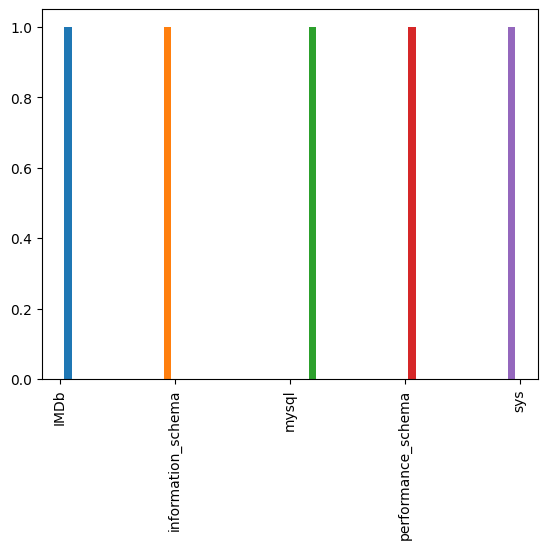

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(my_python_var);
plt.xticks(rotation='vertical');

## 02 Database and Table creation

We have already seen how we inspect the server to see which DBs are present via the command:

```mysql
SHOW DATABASES;
```

We can start interacting with a specific DB by selecting which one to use via 

```mysql
USE <DB_NAME>;
```

If instead we want to create a new DB to work with, we can use the command

```mysql
CREATE DATABASE <DB_NAME>;
```

A more complex sintax can be used to create a new DB if and only if no other DB with the same name already exists.

```mysql
CREATE DATABASE IF NOT EXISTS <DB_NAME>;
```

If the user has been granted the right to access this DB, it's possible to start investigating the content of the DB in use.

Check if a DB named `my_db` exist, and if not, create one. 
Then, switch to the new DB to start using it.

In [11]:
%%sql

CREATE DATABASE IF NOT EXISTS my_db;

 * mysql+mysqlconnector://root:***@db
1 rows affected.


[]

In [12]:
%%sql

SHOW DATABASES;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Database
information_schema
my_db
mysql
performance_schema
sys


In [13]:
%%sql

USE my_db;

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

All tables contained in the DB are shown in a similar way to what used to show all DBs on the server:

```mysql
SHOW TABLES;
```

_NB_: we are inspecting the content of a specific DB (the one selected with `USE <DB_NAME>`)

In [14]:
%%sql 

SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
0 rows affected.


Tables_in_my_db


The analogous pythonic way to execute the same list of commands (using the mysql.connector driver) is the following.

_NB_: This time, as we are not retrieving results from the server but we are instead creating a DB, we have to specify that we want to _commit_ a change to the server; 

In [15]:
# defining the sql command line
sql_ = "CREATE DATABASE IF NOT EXISTS my_db;"

# instructing the cursor to execute it
dbc.execute(sql_)

# in this case the result of the sql transaction is not to return a list of items 
# it is instead a change in the DB structure
# therefore, for the change to have effect, a the change is to be committed to the DB
db.commit() 

All other commands, `USE` and `SHOW`, do not require any change to be committed, therefore we can simply issue them via the cursor.

In [16]:
dbc.execute("USE my_db")

dbc.execute("SHOW TABLES")
dbc.fetchall()

[]

So far the DB is empty, so let's use the same lines presented in the slides to create a dummy `Users` table.

Any table can then be inspected to check its schema by listing all attributes.

1. Create the `Users` table declaring the schema by defining each attributes
2. Check if the table has been created on the DB via a `SHOW` command
3. Check the Table schema by issuing `DESCRIBE <TABLE_NAME>`

In [17]:
%%sql

CREATE TABLE Users (
    UserID varchar(30),
    BadgeNum int(16),
    FirstName varchar(255),
    LastName varchar(255),
    Age int,
    OtherAttr float
);

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [18]:
%%sql 

SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
1 rows affected.


Tables_in_my_db
Users


In [19]:
%%sql

DESCRIBE Users;

 * mysql+mysqlconnector://root:***@db
6 rows affected.


Field,Type,Null,Key,Default,Extra
UserID,b'varchar(30)',YES,,None,
BadgeNum,b'int',YES,,None,
FirstName,b'varchar(255)',YES,,None,
LastName,b'varchar(255)',YES,,None,
Age,b'int',YES,,None,
OtherAttr,b'float',YES,,None,


Following on the lines of the previous examples, perform the same transactions with the `mysql.connector` driver.

This time, as the `Users` table already exists, we can create a `Users_py` table.

Remember:
- Use the DB Cursor to execute the transactions
- Transaction that change the content of the DB have to be _committed_ to the DB
- Transactions returing the content of the DB host their results _in the cursor_

In [20]:
dbc.reset()

In [21]:
# create table
sql_ = "CREATE TABLE Users_py (\
    UserID varchar(30),\
    BadgeNum int(16),\
    FirstName varchar(255),\
    LastName varchar(255),\
    Age int,\
    OtherAttr float\
);"

dbc.execute(sql_)

db.commit()

In [22]:
dbc.execute("SHOW TABLES")

In [23]:
dbc.fetchall()

[('Users',), ('Users_py',)]

In [24]:
# describe table
dbc.execute("DESCRIBE Users_py")

In [25]:
dbc.fetchall()

[('UserID', b'varchar(30)', 'YES', '', None, ''),
 ('BadgeNum', b'int', 'YES', '', None, ''),
 ('FirstName', b'varchar(255)', 'YES', '', None, ''),
 ('LastName', b'varchar(255)', 'YES', '', None, ''),
 ('Age', b'int', 'YES', '', None, ''),
 ('OtherAttr', b'float', 'YES', '', None, '')]

## 03 Declaring contstraints and altering tables

Let's clean up all existing tables in our database.

To remove an existing table from a DB we can issue the instruction:
    
```mysql
DROP TABLE IF EXISTS <NAME OF YOUR TABLE>;
```

Be ***extremely careful*** when doing this... Dropping a Table means losing all records from that table, and severing all connections with other tables based on foreign keys. The entire DB might become unusable!


In [26]:
%%sql 

DROP TABLE IF EXISTS Users;

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

Let's also drop the `Users_py` table using the Python connetor

In [27]:
dbc.execute("DROP TABLE IF EXISTS Users_py")
db.commit()

Create a new `products` table with the following schema:

| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| productID   | Integer | | NOT NULL AUTO_INCREMENT |
| productName | String | Max length 30 | DEFAULT "" |
| unitPrice   | Float | | NOT NULL DEFAULT 99999.99|
| unitsInStock | Integer | Unsigned | NOT NULL DEFAULT 0 |

`productID` will also be our `PRIMARY KEY`

This can be declared either inline or at the end of the table definition:

```mysql
productID INT NOT NULL UNIQUE AUTO_INCREMENT PRIMARY KEY
```

or 

```mysql
productID INT NOT NULL UNIQUE AUTO_INCREMENT
...
PRIMARY KEY (productID)
```

In [28]:
%%sql

CREATE TABLE IF NOT EXISTS products (
         productID    INT          NOT NULL UNIQUE AUTO_INCREMENT PRIMARY KEY,
         productName  VARCHAR(30)  DEFAULT "" ,
         unitPrice    FLOAT        NOT NULL DEFAULT 99999.99,
         unitsInStock INT UNSIGNED NOT NULL DEFAULT 0
);

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [29]:
%%sql

DESCRIBE products;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
productID,b'int',NO,PRI,None,auto_increment
productName,b'varchar(30)',YES,,b'',
unitPrice,b'float',NO,,b'100000',
unitsInStock,b'int unsigned',NO,,b'0',


The table does not contain any constraint, default values, or keys.

A table can be altered by adding/removing Attributes, as well as by adding constraints.

Let's first add a new attribute to the table:

| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| productID   | Integer | | NOT NULL AUTO_INCREMENT |
| productName | String | Max length 30 | DEFAULT "" |
| unitPrice   | Float | | NOT NULL DEFAULT 99999.99|
| unitsInStock | Integer | Unsigned | NOT NULL DEFAULT 0 |
| **isDiscontinued**  | **Bool** | | NOT NULL |

To alter a table and create a new column we can act on it with:

```mysql
ALTER TABLE <THE TABLE>
ADD COLUMN <NEW COL> <THE NEW ATTRIBUTE DECLARATION>;
```


Alter the `products` table and add the `isDiscontinued` attribute

In [30]:
%%sql

ALTER TABLE products
ADD COLUMN isDiscontinued BOOL NOT NULL;

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [31]:
%%sql 

DESCRIBE products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
productID,b'int',NO,PRI,None,auto_increment
productName,b'varchar(30)',YES,,b'',
unitPrice,b'float',NO,,b'100000',
unitsInStock,b'int unsigned',NO,,b'0',
isDiscontinued,b'tinyint(1)',NO,,None,


`isDiscontinued` does however not contain any meaningful constraint or default value.
Let's consider `0` as a good default value:

| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| productID   | Integer | | NOT NULL AUTO_INCREMENT |
| productName | String | Max length 30 | DEFAULT "" |
| unitPrice   | Float | | NOT NULL DEFAULT 99999.99|
| unitsInStock | Integer | Unsigned | NOT NULL DEFAULT 0 |
| isDiscontinued  | Bool | | NOT NULL **DEFAULT 0** |


We can use the same `ALTER TABLE` instruction to do this:
    
```mysql
ALTER TABLE <THE TABLE>
ALTER <ATTRIBUTE> SET DEFAULT <NEW DEFAULT>;
```

In [32]:
%%sql

ALTER TABLE products
ALTER isDiscontinued SET DEFAULT 0;

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [33]:
%%sql 

DESCRIBE products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
productID,b'int',NO,PRI,None,auto_increment
productName,b'varchar(30)',YES,,b'',
unitPrice,b'float',NO,,b'100000',
unitsInStock,b'int unsigned',NO,,b'0',
isDiscontinued,b'tinyint(1)',NO,,b'0',


We can also impose `productName` to be not-null altering the table one final time.

| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| productID   | Integer | | NOT NULL AUTO_INCREMENT |
| productName | String | Max length 30 | **NOT NULL** DEFAULT "" |
| unitPrice   | Float | | NOT NULL DEFAULT 99999.99|
| unitsInStock | Integer | Unsigned | NOT NULL DEFAULT 0 |
| isDiscontinued  | Bool | | NOT NULL DEFAULT 0 |


In MySQL, this implies to modify the entire attribute, thus the Type will have to be re-stated:
    
```mysql
ALTER TABLE <THE TABLE>
MODIFY <ATTRIBUTE> <ATTRIBUTE TYPE> <CONSTRAINT>;
```

In [34]:
%%sql

ALTER TABLE products
MODIFY productName VARCHAR(30) NOT NULL DEFAULT "";

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [35]:
%%sql

DESCRIBE products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
productID,b'int',NO,PRI,None,auto_increment
productName,b'varchar(30)',NO,,b'',
unitPrice,b'float',NO,,b'100000',
unitsInStock,b'int unsigned',NO,,b'0',
isDiscontinued,b'tinyint(1)',NO,,b'0',


Let's now create a `suppliers` table with the following description:

| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| supplierID   | Integer | | NOT NULL AUTO_INCREMENT |
| supplierName | String | Max length 30 | NOT NULL DEFAULT "" |
| countryCode   | Char | Length 3 | NOT NULL |
| email   | String | Max length 30  | NOT NULL |

`supplierID` is going to act as the table's primary key in this case.

In [36]:
%%sql

CREATE TABLE suppliers (
    supplierID      INT NOT NULL UNIQUE AUTO_INCREMENT PRIMARY KEY,
    supplierName    VARCHAR(30) NOT NULL DEFAULT "",
    countryCode     CHAR(3) NOT NULL,
    email           VARCHAR(30) NOT NULL
);


 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [37]:
%%sql

DESCRIBE suppliers;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
supplierID,b'int',NO,PRI,None,auto_increment
supplierName,b'varchar(30)',NO,,b'',
countryCode,b'char(3)',NO,,None,
email,b'varchar(30)',NO,,None,


Alter the table to include a default "ITA" for `countryCode`

In [38]:
%%sql 

ALTER TABLE suppliers 
ALTER countryCode SET DEFAULT "ITA";

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [39]:
%%sql

DESCRIBE suppliers;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
supplierID,b'int',NO,PRI,None,auto_increment
supplierName,b'varchar(30)',NO,,b'',
countryCode,b'char(3)',NO,,b'ITA',
email,b'varchar(30)',NO,,None,


In [40]:
%%sql

SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


Tables_in_my_db
products
suppliers


To enstablish a relation between the `products` and `suppliers` tables, we have to consider that:
    
- a supplier can supply multiple products
- a product can be supplied by multiple suppliers

This is a many-to-many relationship, which requires a supporting external table.

Create a new `supplier_to_product` table with the following attributes:
    
| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| prodID   | Integer | | NOT NULL |
| supID    | Integer | | NOT NULL |


In [41]:
%%sql 

CREATE TABLE supplier_to_product(
    prodID INT NOT NULL,
    supID  INT NOT NULL
);

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [42]:
%%sql 

DESCRIBE supplier_to_product;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


Field,Type,Null,Key,Default,Extra
prodID,b'int',NO,,None,
supID,b'int',NO,,None,


Neither prodID nor supID is a good primary key in this case, as we can have both appearing multiple times in the table.

However, a good primary key for this table is the combination (prodID,supID) which is absolutely unique, and thus, a good key.

We can alter the table to add the primary key statement:
    
```mysql
ALTER TABLE <TABLE>
ADD PRIMARY KEY <ATTRIBUTE COMBINATION>;
```

In [43]:
%%sql

ALTER TABLE supplier_to_product
ADD PRIMARY KEY (prodID,supID);

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [44]:
%%sql

DESCRIBE supplier_to_product;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


Field,Type,Null,Key,Default,Extra
prodID,b'int',NO,PRI,None,
supID,b'int',NO,PRI,None,


Finally, we can link the 3 tables together by stating which attributes act as the foreign keys in the `supplier_to_product` table, and to which Attributes in the parent tables they refer to.

- `prodID` points to the `productID` attribute of `products` table
- `supID` points to the `supplierID` attribute of `supplier` table

```mysql
ALTER TABLE <TABLE>
ADD FOREIGN KEY (<ATTRIBUTE IN THIS TABLE>) REFERENCES <OTHER TABLE>(<ATTRIBUTE IN OTHER TABLE>);
```

In [45]:
%%sql 

ALTER TABLE supplier_to_product 
ADD CONSTRAINT FK_prod
FOREIGN KEY (prodID) REFERENCES products(productID);

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [46]:
%%sql 

ALTER TABLE supplier_to_product 
ADD CONSTRAINT FK_sup
FOREIGN KEY (supID) REFERENCES suppliers(supplierID);

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [47]:
%%sql

DESCRIBE supplier_to_product;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


Field,Type,Null,Key,Default,Extra
prodID,b'int',NO,PRI,None,
supID,b'int',NO,PRI,None,


## 04 Inserting Updating and Deleting records

The tables are currently empty. 
We can inspect the content of the tables by performing a simple query.

```mysql
SELECT * FROM <TABLE>;
```

To insert a single record into a table we can proceed in either of the two following ways:

1. By explicitly specifying the names of the columns when passing the tuple containing the values
```mysql
INSERT INTO <TABLE> (<COLUMN1>, <COLUMN2>, <COLUMN3>, ...)
VALUES (<VALUE1>, <VALUE2>, <VALUE3>, ...);
```
This will work also in the case attributes with a default value will not be explicitely passed


2. By implicitly using all the columns when passing the tuple containing the values
```mysql
INSERT INTO <TABLE> 
VALUES (<VALUE1>, <VALUE2>, ..., <VALUEn>);
```


_NB_: 1. is the usually recommended way to perform a data insertion in SQL.

Using the `mysql.connector` we can formulate the insert in a more pythonic way, e.g. to include this statement programmatically into a loop or a function call:
    
```python
sql_ = "INSERT INTO <TABLE> (<COLUMN1>, <COLUMN2>, <COLUMN3>, ...) VALUES (%s, %s, %s, ...)"
val_ = (<VALUE1>, <VALUE2>, <VALUE3>, ...)
db_cursor.execute(sql_, val_)
db.commit()
```

Being an active change to the DB istance (the data contained in the DB itself), remember to commit the insert.

- Verify that the product table is actually empty
- Isert the following list of products in the `products` table
- Check the content of the table after the transaction, to verify that both the AUTO_INCREMENT key and the default values have taken into account


| productName | unitPrice | unitsInStock | isDiscontinued | 
| --- | --- | --- |--- |
| "Founders Porter" | 4.9 | 12 | 0 |


In [48]:
%%sql

SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
0 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued


In [49]:
%%sql

INSERT INTO products (productName, unitPrice, unitsInStock, isDiscontinued)
VALUES ("Founders Porter", 4.9, 12, 0);

 * mysql+mysqlconnector://root:***@db
1 rows affected.


[]

In [50]:
%%sql

SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
1 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued
1,Founders Porter,4.9,12,0


Multi-values insert can be performed in a completely similar way, by separating multiple tuples by a comma:
    
```mysql
INSERT INTO <TABLE> (<COLUMN1>, <COLUMN2>, <COLUMN3>, ...)
VALUES 
(<VALUE11>, <VALUE12>, <VALUE13>, ...), 
(<VALUE21>, <VALUE22>, <VALUE23>, ...), 
(<VALUE31>, <VALUE32>, <VALUE33>, ...), 

```

The python-based command is similar to the previous one, but is drop the `execute` in favor of `executemany`, using as value a list of tuples

```python
sql_ = "INSERT INTO <TABLE> (<COLUMN1>, <COLUMN2>, <COLUMN3>, ...) VALUES (%s, %s, %s, ...)"
val_ = [
    (<VALUE11>, <VALUE12>, <VALUE13>, ...),
    (<VALUE21>, <VALUE22>, <VALUE23>, ...),
    (<VALUE31>, <VALUE32>, <VALUE33>, ...) ]
db_cursor.executemany(sql_, val_)
db.commit()
```


Add a few more products to the `product` table:
    
| productName | unitPrice | unitsInStock | isDiscontinued | 
| --- | --- | --- |--- |
| "Punk IPA" | 5.2 | 45 |  |
| "HB Dunkel" | 4.5 | 250 |  |
| "Forst Xmas " | 8.0 | 2 |  |
| "Damm Complot " | 3.7 | 120 |  |
     

In [51]:
%%sql

INSERT INTO products (productName, unitPrice, unitsInStock)
VALUES     ('Punk IPA',     5.2,  45),
    ('HB Dunkel',    4.5, 250),
    ('Forst Xmas',   8.0,   2),
    ('Damm Complot', 3.7, 120);


 * mysql+mysqlconnector://root:***@db
4 rows affected.


[]

In [52]:
%%sql 

SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued
1,Founders Porter,4.9,12,0
2,Punk IPA,5.2,45,0
3,HB Dunkel,4.5,250,0
4,Forst Xmas,8.0,2,0
5,Damm Complot,3.7,120,0


Updating entries is a more delicate issue, as in a DB we can in principle modify all records associated with a number of conditions.
This makes the update operation quite powerful and possibly very error prone if not performed with extreme caution.

```mysql
UPDATE <TABLE>
SET <ATTRIBUTE> = <NEW VALUE>
WHERE <CONDITION>;
```

or

```python
sql_ = "UPDATE <TABLE> SET <ATTRIBUTE> = <NEW VALUE> WHERE <CONDITION>"
db_cursor.execute(sql)
db.commit()

```

Let's update a single record with a "very explicit" condition statement:

- Assign `isDiscontinued` equal to 1 to the "Forst Xmas" product
- Check if the update has taken place

In [53]:
%%sql

UPDATE products
SET isDiscontinued = 1
WHERE (productName = "Forst Xmas");

 * mysql+mysqlconnector://root:***@db
1 rows affected.


[]

In [54]:
%%sql

SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued
1,Founders Porter,4.9,12,0
2,Punk IPA,5.2,45,0
3,HB Dunkel,4.5,250,0
4,Forst Xmas,8.0,2,1
5,Damm Complot,3.7,120,0


Similarly, deleting entries is quite a risky task if not done with plenty of caution, as a wrong `WHERE` condition might inadvertly lead to the deletion of a large part of your DB records. 

Remember, with `DELETE` we do remove entire records (i.e. tuples) from the DB, not just the content of the `WHERE` conditional statement. 

```mysql
DELETE FROM <TABLE>
WHERE <CONDITION>;
```

or

```python
sql_ = "DELETE FROM <TABLE> WHERE <CONDITION>"
db_cursor.execute(sql)
db.commit()

```

- Delete all products whose name begins with 'F' and ends with 's'
- Check if the update has taken place

In [55]:
%%sql

DELETE FROM products
WHERE (productName LIKE 'F%s');

 * mysql+mysqlconnector://root:***@db
1 rows affected.


[]

In [56]:
%%sql

SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued
1,Founders Porter,4.9,12,0
2,Punk IPA,5.2,45,0
3,HB Dunkel,4.5,250,0
5,Damm Complot,3.7,120,0


- Populate the `suppliers` table according to the following list


| supplierName | countryCode | email|
| --- | --- | ---|
| "A hop in the park" | "USA" | "contactme@ahop.com" |
| "Allez Hops! Cave à bièr" | "FRA" | "itsme@allezhops.com" |
| "Wild Hops " | "ITA" | "myemail@wildhops.it" |
|"Beer Paradise"|"ITA"|"beer@beerparadise.it"|


In [57]:
%%sql

INSERT INTO suppliers (supplierName, countryCode, email) 
VALUES
("A hop in the park","USA","contactme@ahop.com"),
("Allez Hops! Cave à bièr","FRA","itsme@allezhops.com"),
("Wild Hops","ITA","myemail@wildhops.it"),
("Beer Paradise","ITA","beer@beerparadise.it");

 * mysql+mysqlconnector://root:***@db
4 rows affected.


[]

In [58]:
%%sql

SELECT * FROM suppliers;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


supplierID,supplierName,countryCode,email
1,A hop in the park,USA,contactme@ahop.com
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com
3,Wild Hops,ITA,myemail@wildhops.it
4,Beer Paradise,ITA,beer@beerparadise.it


Complete the DB with the two additional steps:

- Update the "A hop in the park" email address to "anewemail@ahop.com"
- Populate the table of connections between products and suppliers
    - Remember that the `supplier_to_product` table is linked to the other two via the respective Foreign Keys 

| supplier | products provided |
| --- | --- | 
| "A hop in the park" | "Punk IPA", "HB Dunkel" |

In [59]:
sql_ = "UPDATE suppliers SET email = %s WHERE supplierName LIKE %s;"
val_ = ('anewemail@ahop.com', 'A hop%')
dbc.execute(sql_, val_)
db.commit()
     
dbc.execute("SELECT * FROM suppliers"); 
dbc.fetchall()

[(1, 'A hop in the park', 'USA', 'anewemail@ahop.com'),
 (2, 'Allez Hops! Cave à bièr', 'FRA', 'itsme@allezhops.com'),
 (3, 'Wild Hops', 'ITA', 'myemail@wildhops.it'),
 (4, 'Beer Paradise', 'ITA', 'beer@beerparadise.it')]

In [61]:
%%sql 

SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued
1,Founders Porter,4.9,12,0
2,Punk IPA,5.2,45,0
3,HB Dunkel,4.5,250,0
5,Damm Complot,3.7,120,0


In [62]:
%%sql 

SELECT * FROM suppliers;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


supplierID,supplierName,countryCode,email
1,A hop in the park,USA,anewemail@ahop.com
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com
3,Wild Hops,ITA,myemail@wildhops.it
4,Beer Paradise,ITA,beer@beerparadise.it


In [63]:
%%sql

DESCRIBE supplier_to_product;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


Field,Type,Null,Key,Default,Extra
prodID,b'int',NO,PRI,None,
supID,b'int',NO,PRI,None,


In [64]:
%%sql

INSERT INTO supplier_to_product (supID, prodID)
VALUES (1, 2),
       (1, 3);

 * mysql+mysqlconnector://root:***@db
2 rows affected.


[]

In [65]:
%%sql 

SELECT * FROM supplier_to_product;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


prodID,supID
2,1
3,1


Export the DB you have created into a .sql file, and store it for later use.

1. connect to the "server" docker container using bash
2. dump the DB via the command:
    
```bash
$ mysqldump -u <USER> -p <DB NAME>  >  <FULL/PATH/TO/NEW/DB_DUMP.sql>
```

3. use the folder `/mapd-workspace/dbs` to store the file, as it's the one currently visible from both in- and out-side the container

## 04 Basic queries 

### EDIT (same info in Section 05) ###

If you have saved your DB locally into a `.sql` file, you can restore it by loading it into the server.

1. Create a new DB named `my_db`
```
CREATE DATABASE IF NOT EXISTS my_db;
```
2. Login in interactive mode into the MySQL server 
```bash 
$ docker exec -it mysql_db_1 bash
```
2. Import the content of the `.sql` file (e.g. `/mapd-workspace/dbs/my_db.sql`) into the newly created DB
    
```bash
$ mysql -u root -p my_db < /mapd-workspace/dbs/my_db.sql
```


The `SELECT` statement allows to perform queries and to retrieve data from a DB.

We can perform queries on 1 single Table in the DB, as well as perform complex queries that span multiple interconnected Tables, with one-to-one, one-to-many and many-to-many relationships across records.

Any `SELECT` statement is composed by at least:
    
```mysql
SELECT <TABLE2.ATTRIBUTE1>, <TABLE1.ATTRIBUTE2>   --# the list of attributes to show
                                                  --# the * wildcard symbol means ALL attributes
    
FROM <TABLE1>, <TABLE2>                           --# the table, or list of tables 
                                                  --# from which to extract the attributes

WHERE <CONDITIONS>                                --# (optional) condition statement
```

The same goes for the pythonc connector-based way

```python
db_cursor.execute("""SELECT <TABLE2.ATTRIBUTE1>, <TABLE1.ATTRIBUTE2>"""
                  """FROM <TABLE1>, <TABLE2>"""
                  """WHERE <CONDITIONS>""")
res_ = db_cursor.fetchall()
for _ in res_:
    print(_)
```

As an alternative, `db_cursor.fetchone()` can be used to printout only 1 out of possibly many records.


- Get the email of all suppliers from Italy

In [6]:
%%sql
use my_db

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [7]:
%%sql

SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
3 rows affected.


Tables_in_my_db
products
supplier_to_product
suppliers


In [8]:
%%sql

DESCRIBE suppliers;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
supplierID,b'int',NO,PRI,None,auto_increment
supplierName,b'varchar(30)',NO,,b'',
countryCode,b'char(3)',NO,,b'ITA',
email,b'varchar(30)',NO,,None,


In [9]:
%%sql

SELECT email
FROM suppliers
WHERE (countryCode = "ITA");

 * mysql+mysqlconnector://root:***@db
2 rows affected.


email
myemail@wildhops.it
beer@beerparadise.it


- Get all information for products with unit price greater than 4

In [10]:
%%sql

DESCRIBE products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
productID,b'int',NO,PRI,None,auto_increment
productName,b'varchar(30)',NO,,b'',
unitPrice,b'float',NO,,b'100000',
unitsInStock,b'int unsigned',NO,,b'0',
isDiscontinued,b'tinyint(1)',NO,,b'0',


In [11]:
%%sql

SELECT *
FROM products
WHERE (unitPrice > 4);

 * mysql+mysqlconnector://root:***@db
3 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued
1,Founders Porter,4.9,12,0
2,Punk IPA,5.2,45,0
3,HB Dunkel,4.5,250,0


- Select all products with unit cost less than 5 and list them in descending order of units in stock

In [12]:
%%sql

SELECT *
FROM products
WHERE (unitPrice<5)
ORDER BY unitsInStock DESC;

 * mysql+mysqlconnector://root:***@db
3 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued
3,HB Dunkel,4.5,250,0
5,Damm Complot,3.7,120,0
1,Founders Porter,4.9,12,0


**Group by** is a common statement which allows to perform data aggregation.

If familiar with `pandas`, this should not come any new to you.

Just remember:
1. No group by statement is possible without an aggregation function.
2. Group by are quite computationally expensive. In case of large databases group by operations might require a long time to execute

- plot the distribution of suppliers by country

In [17]:
%%sql

SELECT  countryCode, COUNT(countryCode) AS nSupp
FROM suppliers
GROUP BY countryCode;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


email,nSupp
anewemail@ahop.com,1
itsme@allezhops.com,1
myemail@wildhops.it,1
beer@beerparadise.it,1


In [18]:
res_ = %sql SELECT COUNT(countryCode) AS count, countryCode FROM suppliers GROUP BY countryCode;

print (res_);

 * mysql+mysqlconnector://root:***@db
3 rows affected.
+-------+-------------+
| count | countryCode |
+-------+-------------+
|   1   |     USA     |
|   1   |     FRA     |
|   2   |     ITA     |
+-------+-------------+


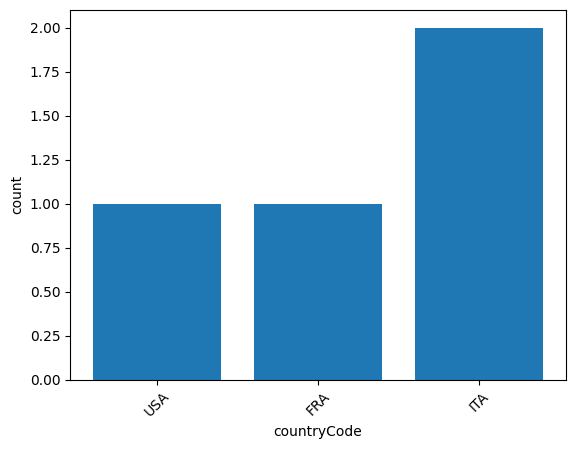

In [19]:
res_.bar();

The main strength of Relational DBs is the possibility of matching information from different tables though **Join** operations.

A join, either performed explicitely or implicitely is:

Just remember:
1. Computationally expensive. In case of large databases group by operations might require a long time to execute
2. Very easy to be done wrong, thus resulting in non-meaningful results

Be sure on which attributes (most often keys) you are performing a join operation.

- Join the `supplier_to_product` table with the `suppliers` table 

In [20]:
%%sql

DESCRIBE suppliers;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
supplierID,b'int',NO,PRI,None,auto_increment
supplierName,b'varchar(30)',NO,,b'',
countryCode,b'char(3)',NO,,b'ITA',
email,b'varchar(30)',NO,,None,


In [21]:
%%sql

DESCRIBE supplier_to_product;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


Field,Type,Null,Key,Default,Extra
prodID,b'int',NO,PRI,None,
supID,b'int',NO,PRI,None,


In [22]:
%%sql

SELECT *
FROM suppliers, supplier_to_product
WHERE suppliers.supplierID = supplier_to_product.supID;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


supplierID,supplierName,countryCode,email,prodID,supID
1,A hop in the park,USA,anewemail@ahop.com,2,1
1,A hop in the park,USA,anewemail@ahop.com,3,1


In [23]:
%%sql

SELECT *
FROM suppliers
INNER JOIN supplier_to_product ON suppliers.supplierID = supplier_to_product.supID;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


supplierID,supplierName,countryCode,email,prodID,supID
1,A hop in the park,USA,anewemail@ahop.com,2,1
1,A hop in the park,USA,anewemail@ahop.com,3,1


In [24]:
%%sql

SELECT *
FROM suppliers
LEFT JOIN supplier_to_product ON suppliers.supplierID = supplier_to_product.supID;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


supplierID,supplierName,countryCode,email,prodID,supID
1,A hop in the park,USA,anewemail@ahop.com,2,1
1,A hop in the park,USA,anewemail@ahop.com,3,1
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com,None,None
3,Wild Hops,ITA,myemail@wildhops.it,None,None
4,Beer Paradise,ITA,beer@beerparadise.it,None,None


In [25]:
%%sql

SELECT *
FROM suppliers
RIGHT JOIN supplier_to_product ON suppliers.supplierID = supplier_to_product.supID;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


supplierID,supplierName,countryCode,email,prodID,supID
1,A hop in the park,USA,anewemail@ahop.com,2,1
1,A hop in the park,USA,anewemail@ahop.com,3,1


We can concatenate multiple join operations to extract higher level information out of the connections stored in the DB

- Add the corresponding product names the the previous join

In [26]:
%%sql

DESCRIBE products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
productID,b'int',NO,PRI,None,auto_increment
productName,b'varchar(30)',NO,,b'',
unitPrice,b'float',NO,,b'100000',
unitsInStock,b'int unsigned',NO,,b'0',
isDiscontinued,b'tinyint(1)',NO,,b'0',


In [ ]:
%%sql

SELECT *
FROM supplier_to_product
INNER JOIN suppliers ON suppliers.supplierID = supplier_to_product.supID
INNER JOIN products  ON products.productID   = supplier_to_product.prodID;

The conjunction of `SELECT`, `GROUP BY` and `JOIN` statements will allow us to extract non trivial information out of any Relational DB.

Add the following records to the `supplier_to_product` table and perform the following queries:
    
| supplier | products provided |
| --- | --- | 
| "Wild Hops" | "Founders Porter", "Punk IPA", "HB Dunkel", "Damm Complot" |    
| "Beer Paradise" | "Punk IPA", "Damm Complot" |    
| "Allez Hops! Cave à bièr" | "Founders Porter", "HB Dunkel" |    

1. show all suppliers of "Damm Complot"
2. retrieve the email address of all possible suppliers of "Punk IPA"
3. list the unit price of all products supplied by Italian firms, listed in descending order   

In [30]:
dbc.execute("USE my_db")

In [31]:
sql_ = "INSERT INTO supplier_to_product (prodID, supID) VALUES (%s, %s)"
val_ = [
    # supplier Allez Hops
    (1, 2),
    (3, 2),

    # supplier Wild Hops
    (1, 3),
    (2, 3),
    (3, 3),
    (5, 3),

    # supplier Beer Paradise
    (2, 4),
    (5, 4),
]


dbc.executemany(sql_, val_)
db.commit()
     
dbc.execute("SELECT * FROM supplier_to_product"); 
for _ in dbc:
     print(_)

(2, 1)
(3, 1)
(1, 2)
(3, 2)
(1, 3)
(2, 3)
(3, 3)
(5, 3)
(2, 4)
(5, 4)


#### 1 - show all suppliers of "Damm Complot"

In [32]:
%%sql

SELECT suppliers.supplierName
FROM supplier_to_product
INNER JOIN suppliers ON supplier_to_product.supID = suppliers.supplierID
INNER JOIN products ON supplier_to_product.prodID = products.productID
WHERE products.productName = "Damm Complot";

 * mysql+mysqlconnector://root:***@db
2 rows affected.


supplierName
Wild Hops
Beer Paradise


#### 2 - retrieve the email address of all possible suppliers of "Punk IPA"

In [33]:
%%sql

SELECT suppliers.email 
FROM supplier_to_product
INNER JOIN suppliers ON supplier_to_product.supID = suppliers.supplierID
INNER JOIN products ON supplier_to_product.prodID = products.productID
WHERE products.productName = "Punk IPA";

 * mysql+mysqlconnector://root:***@db
3 rows affected.


email
anewemail@ahop.com
myemail@wildhops.it
beer@beerparadise.it


#### 3 - list the unit price of all products supplied by Italian firms, listed in descending order   

In [34]:
%%sql

SELECT DISTINCT products.unitPrice, products.productName
FROM supplier_to_product
INNER JOIN suppliers ON supplier_to_product.supID = suppliers.supplierID
INNER JOIN products ON supplier_to_product.prodID = products.productID
WHERE suppliers.countryCode = "ITA"
ORDER BY unitPrice DESC;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


unitPrice,productName
5.2,Punk IPA
4.9,Founders Porter
4.5,HB Dunkel
3.7,Damm Complot


## 05 Queries on well-formed DBs

In MySQL we can load entire DBs from external files.

The files will contain the full DB structure (tables and constraints) and will populate all tables with all records 

To load a DB into the MySQL server from the interactive docker shell, we can simply do the following:

1. Create a new DB named `world`
2. Import the content of the file `/mapd-workspace/dbs/world.sql` into the newly created DB via
    
```bash
$ mysql -u root -p world < /mapd-workspace/dbs/world.sql
```

_NB_: The `opt/workspace` directory has been defined as a Docker Volume, and is a shared location with your computer...

Using the `world` DB, perform queries to answer the folliwing questions.

Additional references can be found here https://dev.mysql.com/doc/world-setup/en/


Use a single query to answer the questions

1. Which country has the largest population?
2. Get the total number of cities in Canada.
3. Select the country with the most cities.
4. List all the languages spoken in the Southeast Asia region.
5. Identify the 5 most spoken language by number of countries.
6. What is the total population of the cities in the Caribbean region?
7. What Countries have a City named "Kingston"?
8. Plot the population density by country, limiting to the 25 with least density.
9. Plot the GNP (Gross Nation Product) of all countries that become independent between 1850 and 1910, limiting to the 10 with highest GNP.
10. Create a scatter plot of the life expentency vs the GNP of all countries that have Spanish as their Official language.


Suggestions:
- Start by inspecting the DB tables structure
- When in doubt, check the table content by selecting a few lines (use `LIMIT` to avoid returining all records)
- Before finalizing the query, you can always perform "intermediate" queries to check if complex operations (groupby and join mostly) are stated correctly

In [17]:
%%sql

USE world; 

SHOW TABLES;


 * mysql+mysqlconnector://root:***@db
0 rows affected.
3 rows affected.


Tables_in_world
city
country
countrylanguage


#### 1 - Which country has the largest population?

In [19]:
%%sql 

SELECT name, population  
FROM country
ORDER BY  population  DESC
LIMIT 1;

 * mysql+mysqlconnector://root:***@db
1 rows affected.


name,population
China,1277558000


#### 2 - Get the total number of cities in Canada.

In [20]:
%%sql 
DESCRIBE city;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
ID,b'int',NO,PRI,None,auto_increment
Name,b'char(35)',NO,,b'',
CountryCode,b'char(3)',NO,MUL,b'',
District,b'char(20)',NO,,b'',
Population,b'int',NO,,b'0',


In [21]:
%%sql 

SELECT COUNT(name) AS CitiesInCanada
FROM city
WHERE(CountryCode='CAN');

 * mysql+mysqlconnector://root:***@db
1 rows affected.


CitiesInCanada
49


#### 3 - Select the country with the most cities.

In [25]:
%%sql 

SELECT COUNT(CountryCode) AS CityCount, CountryCode
FROM city
GROUP BY CountryCode
ORDER BY CityCount DESC
LIMIT 10;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


CityCount,CountryCode
363,CHN
341,IND
274,USA
250,BRA
248,JPN
189,RUS
173,MEX
136,PHL
93,DEU
85,IDN


#### 4 - List all the languages spoken in the 'Southeast Asia' region.

In [23]:
%%sql 
DESCRIBE countrylanguage

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
CountryCode,b'char(3)',NO,PRI,b'',
Language,b'char(30)',NO,PRI,b'',
IsOfficial,"b""enum('T','F')""",NO,,b'F',
Percentage,"b'decimal(4,1)'",NO,,b'0.0',


In [44]:
%%sql

SELECT DISTINCT L.Language
FROM countrylanguage L
INNER JOIN country C ON C.Code=L.CountryCode
WHERE(C.Region  = 'Southeast Asia')
ORDER BY L.Language;

 * mysql+mysqlconnector://root:***@db
47 rows affected.


Language
Bali
Banja
Batakki
Bicol
Bugi
Burmese
Cebuano
Chin
Chinese
Dusun


#### 5 - Identify the 5 most spoken language by number of countries.

In [48]:
%%sql

SELECT Language, COUNT(Language)
FROM countrylanguage
GROUP BY Language
ORDER BY COUNT(Language) DESC
LIMIT 10;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


Language,COUNT(Language)
English,60
Arabic,33
Spanish,28
French,25
German,19
Chinese,19
Russian,17
Italian,15
Creole English,14
Portuguese,12


#### 6 - What is the total population of the cities in the Caribbean region?

In [56]:
%%sql

SELECT T.Name, T.Population #SUM(T.Population) ?
FROM city T
LEFT JOIN country C ON C.Code=T.CountryCode
WHERE(C.Region='Caribbean');

 * mysql+mysqlconnector://root:***@db
58 rows affected.


Name,Population
Oranjestad,29034
South Hill,961
The Valley,595
Willemstad,2345
Saint John´s,24000
Nassau,172000
Bridgetown,6070
La Habana,2256000
Santiago de Cuba,433180
Camagüey,298726


#### 7 - What Countries have a City named "Kingston"?

In [71]:
%%sql

SELECT C.Name
FROM city T
RIGHT JOIN country C ON C.Code=T.CountryCode
WHERE(T.Name LIKE "%Kingston%");

 * mysql+mysqlconnector://root:***@db
3 rows affected.


Name
United Kingdom
Jamaica
Norfolk Island


#### 8 - Plot the population density by country, limiting to the 25 with least density.

 * mysql+mysqlconnector://root:***@db
25 rows affected.
+----------------------------------------------+---------+
|                     Name                     | Density |
+----------------------------------------------+---------+
|     United States Minor Outlying Islands     |  0.0000 |
|        British Indian Ocean Territory        |  0.0000 |
|      Heard Island and McDonald Islands       |  0.0000 |
| South Georgia and the South Sandwich Islands |  0.0000 |
|                Bouvet Island                 |  0.0000 |
|         French Southern territories          |  0.0000 |
|                  Antarctica                  |  0.0000 |
|                  Greenland                   |  0.0259 |
|            Svalbard and Jan Mayen            |  0.0513 |
|               Falkland Islands               |  0.1643 |
|                   Pitcairn                   |  1.0204 |
|                Western Sahara                |  1.1015 |
|                   Mongolia                   |  1.6993 |


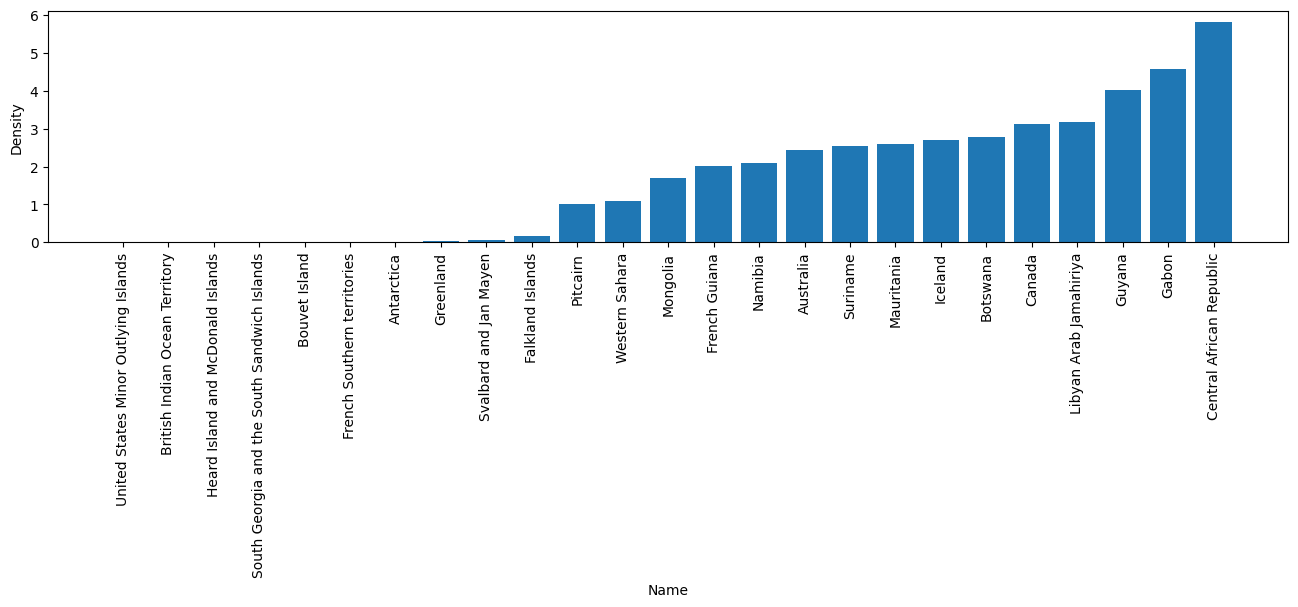

In [83]:
res_ = %sql SELECT  Name, Population/SurfaceArea AS Density FROM  country ORDER BY Density ASC LIMIT 25;

print(res_)

import matplotlib.pyplot as plt
plt.figure(figsize=(16,3))
res_.bar();
plt.xticks(rotation='vertical');

#### 9 - Plot the GNP (Gross Nation Product) of all countries that become independent between 1850 and 1910, limiting to the 10 with highest GNP.

 * mysql+mysqlconnector://root:***@db
10 rows affected.
+--------------+------------+
|     Name     |    GNP     |
+--------------+------------+
|    Italy     | 1161755.00 |
|    Canada    | 598862.00  |
|  Australia   | 351182.00  |
|     Iran     | 195746.00  |
|    Norway    | 145895.00  |
| South Africa | 116729.00  |
| New Zealand  |  54669.00  |
|   Romania    |  38158.00  |
|     Cuba     |  17843.00  |
|  Luxembourg  |  16321.00  |
+--------------+------------+


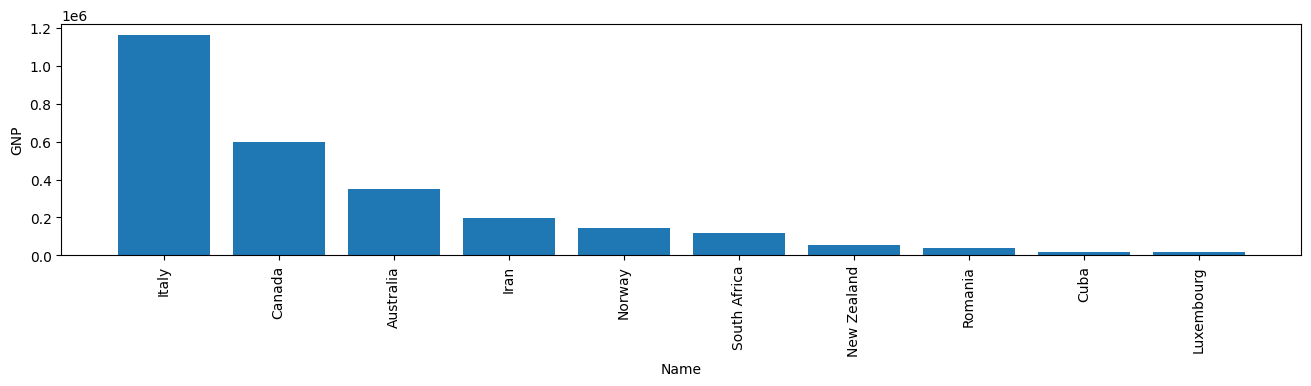

In [85]:
res_ = %sql SELECT Name, GNP FROM country WHERE(IndepYear BETWEEN 1850 AND 1910) ORDER BY  GNP DESC LIMIT 10;

print(res_)

plt.figure(figsize=(16,3))
res_.bar();
plt.xticks(rotation='vertical');

#### 10 - Create a scatter plot of the life expentency vs the GNP of all countries that have Spanish as their Official language.

In [48]:
res_ = %sql SELECT C.GNP, C.LifeExpectancy, C.Name \
            FROM  country C \
            RIGHT JOIN countrylanguage L ON  C.Code = L.CountryCode \
            WHERE(L.Language='Spanish') \
            AND(L.IsOfficial='T') ;

print(res_)

plt.figure(figsize=(8,6))
for _ in res_:
    plt.scatter(_[0],_[1],s=50);
    plt.annotate(_[2], (float(_[0])*1.002,float(_[1])*1.002));
plt.xlabel('GNP')
plt.ylabel('LifeExpectancy')


 * mysql+mysqlconnector://root:***@db
(mysql.connector.errors.ProgrammingError) 1146 (42S02): Table 'IMDb.countrylanguage' doesn't exist
[SQL: SELECT C.GNP, C.LifeExpectancy, C.Name FROM country C RIGHT JOIN countrylanguage L ON C.Code = L.CountryCode WHERE(L.Language='Spanish') AND(L.IsOfficial='T') ;]
(Background on this error at: https://sqlalche.me/e/14/f405)
None


TypeError: 'NoneType' object is not iterable

<Figure size 800x600 with 0 Axes>

## 06 More on queries 

Let' import a well-structured DB, with several tables and relationships, to be used as a sandbox for further exercises on queries.

The `.sql` file can be found at: `/mapd-workspace/dbs/IMDb_pruned.sql`.

The DB is freely available and is taken from the IMDb (Internet Movie Database) website (https://www.imdb.com/interfaces/).

The entire database is composed of a dozen of tables, hosing all people involved in Movies, Shorts, TV Show Epidoses and more since the 1890s. 

To simplify the execution of queries, we will work with a slimmed-down version of the entire DB, with still plenty of records for us to extract interesting information.

1. Create a new DB named `IMDb`
2. Import the content of the file `/mapd-workspace/dbs/IMDb_pruned.sql` into the newly created DB
(this might take a minute or two...)

### Check which tables are available

In [12]:
%%sql
USE IMDb;
SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
0 rows affected.
7 rows affected.


Tables_in_IMDb
Directors
Episode_belongs_to
Had_role
Names_
Title_genres
Title_ratings
Titles


### Describe the content of table Names_

In [12]:
%%sql
DESCRIBE Names_;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
name_id,b'varchar(255)',NO,,None,
name_,b'varchar(255)',NO,,None,
birth_year,b'smallint',YES,,None,
death_year,b'smallint',YES,,None,


### People by birth year

A) Start by limiting the query to 1000 entries

1. Draw an histogram of the year of birth
2. Draw a second histogram with the year of birth of the 1000 youngest people in the list

In [13]:
%%sql
SELECT * FROM Names_
LIMIT 10

 * mysql+mysqlconnector://root:***@db
10 rows affected.


name_id,name_,birth_year,death_year
nm0000002,Lauren Bacall,1924,2014
nm0000003,Brigitte Bardot,1934,None
nm0000005,Ingmar Bergman,1918,2007
nm0000008,Marlon Brando,1924,2004
nm0000013,Doris Day,1922,2019
nm0000014,Olivia de Havilland,1916,2020
nm0000016,Georges Delerue,1925,1992
nm0000017,Marlene Dietrich,1901,1992
nm0000018,Kirk Douglas,1916,2020
nm0000019,Federico Fellini,1920,1993


 * mysql+mysqlconnector://root:***@db
81 rows affected.


([<matplotlib.axis.XTick at 0x7fc7686eb340>,
 [Text(0, 0, '1897'),
  Text(10, 0, '1910'),
  Text(20, 0, '1921'),
  Text(30, 0, '1931'),
  Text(40, 0, '1941'),
  Text(50, 0, '1951'),
  Text(60, 0, '1961'),
  Text(70, 0, '1971'),
  Text(80, 0, '1982')])

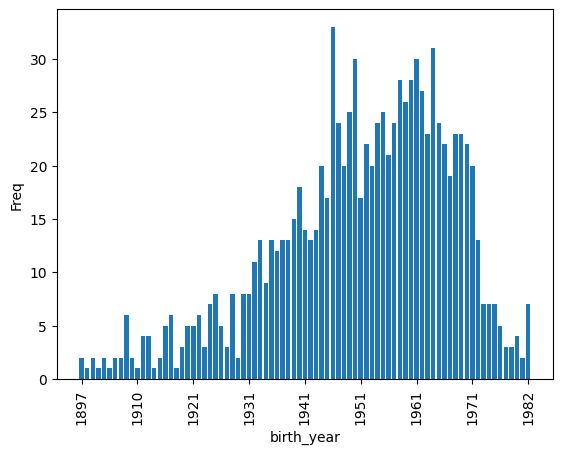

In [14]:
import numpy as np
import matplotlib.pyplot as plt

bdy1 = %sql SELECT birth_year, count(birth_year) AS Freq FROM( SELECT * FROM Names_ LIMIT 1000 ) AS limited_names \
GROUP BY birth_year \
ORDER BY birth_year

bdy1.bar()
plt.xticks(ticks=np.arange(0,len(bdy1),10) ,rotation='vertical')

 * mysql+mysqlconnector://root:***@db
19 rows affected.


<BarContainer object of 19 artists>

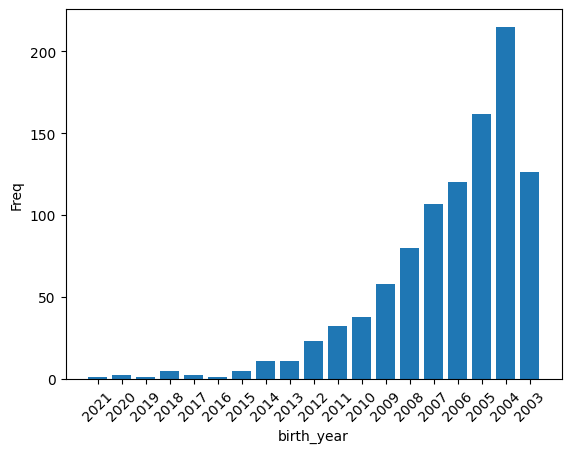

In [15]:
bdy2 = %sql SELECT birth_year, count(birth_year) AS Freq \
FROM( SELECT * FROM Names_ ORDER BY birth_year DESC LIMIT 1000 ) AS limorder_names \
GROUP BY birth_year  \
  

bdy2.bar()

B) Extend the query to all records in the table

1. Check for outliers (inspect min and max)
2. If any outlier is found, limit the query to a reasonable range (at least people born after 1850)
3. Draw a new histogram with the year of birth
4. Compute the mean and std of year of birth

 * mysql+mysqlconnector://root:***@db
142 rows affected.


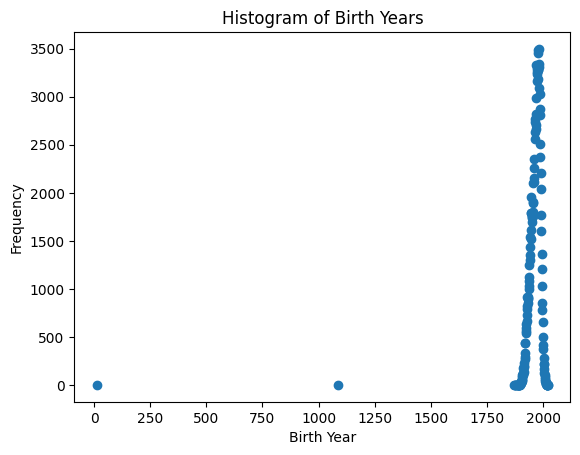

In [17]:
bdy = %sql SELECT birth_year, count(birth_year) AS Freq \
FROM Names_ \
GROUP BY birth_year \
ORDER BY birth_year

bdy = np.array(bdy)
#print(bdy)


# create a list of birth years and frequencies from the SQL query result
birth_years = bdy[:,0]
frequencies = bdy[:,1]

# create a histogram with 10 bins and add labels and a title
plt.scatter(birth_years, frequencies)
plt.xlabel('Birth Year')
plt.ylabel('Frequency')
plt.title('Histogram of Birth Years')

# show the plot
plt.show()

In [18]:
bdy3 = %sql SELECT birth_year, count(birth_year) AS Freq \
FROM( SELECT * FROM Names_ WHERE(birth_year > 1850) ) AS correct_names \
GROUP BY birth_year \
ORDER BY birth_year

 * mysql+mysqlconnector://root:***@db
140 rows affected.


([<matplotlib.axis.XTick at 0x7f8fb8a5ca00>,
 [Text(0, 0, '1870'),
  Text(10, 0, '1892'),
  Text(20, 0, '1902'),
  Text(30, 0, '1912'),
  Text(40, 0, '1922'),
  Text(50, 0, '1932'),
  Text(60, 0, '1942'),
  Text(70, 0, '1952'),
  Text(80, 0, '1962'),
  Text(90, 0, '1972'),
  Text(100, 0, '1982'),
  Text(110, 0, '1992'),
  Text(120, 0, '2002'),
  Text(130, 0, '2012')])

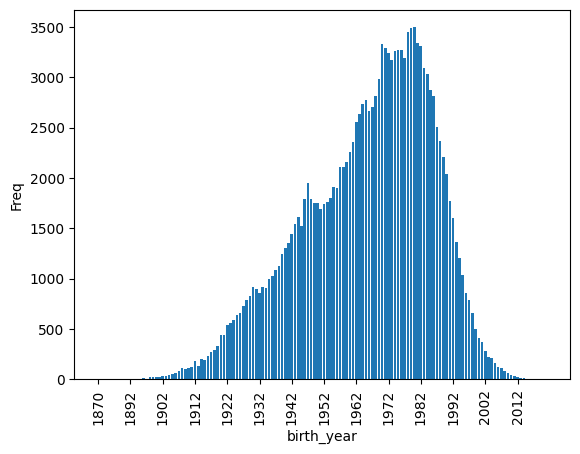

In [19]:
bdy3.bar()
plt.xticks(ticks=np.arange(0,len(bdy3),10) ,rotation='vertical')

In [20]:
%%sql
SELECT AVG(birth_year) AS mean_birth_year, STDDEV(birth_year) AS std_birth_year
FROM Names_;

 * mysql+mysqlconnector://root:***@db
1 rows affected.


mean_birth_year,std_birth_year
1965.4332,20.712074263741645


### Movie stats

1. Plot how many titles can be found in the DB per year, over the past 25 years
2. List the names of all actors who have had the role of Spider-Man and the corresponding Title
3. List and count the 10 people who appeared the most in movies by "Wes Anderson"

In [21]:
%%sql
SELECT * FROM Titles LIMIT 5

 * mysql+mysqlconnector://root:***@db
5 rows affected.


title_id,title_type,primary_title,start_year,runtime_minutes
tt0011216,movie,b'Spanish Fiesta',2019,67
tt0015724,movie,b'Dama de noche',1993,102
tt0035423,movie,b'Kate & Leopold',2001,118
tt0059325,movie,"b""Born in '45""",1990,100
tt0059900,movie,"b'Wenn du gro\xc3\x9f bist, lieber Adam'",1990,78


#### 1 - Plot how many titles can be found in the DB per year, over the past 25 years

 * mysql+mysqlconnector://root:***@db
30 rows affected.


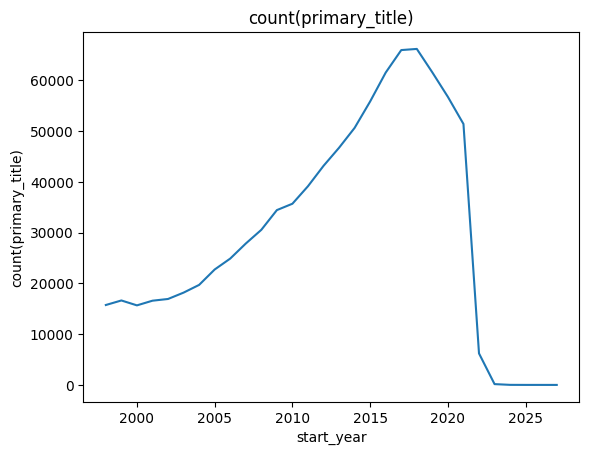

In [22]:
tit25 = %sql SELECT start_year, count(primary_title) FROM Titles WHERE(start_year>1997) GROUP BY start_year ORDER BY start_year
tit25.plot()

#### 2 - List the names of all actors who have had the role of Spider-Man and the corresponding Title 

In [23]:
%%sql
SELECT * FROM Names_ LIMIT 10

 * mysql+mysqlconnector://root:***@db
10 rows affected.


name_id,name_,birth_year,death_year
nm0000002,Lauren Bacall,1924,2014
nm0000003,Brigitte Bardot,1934,None
nm0000005,Ingmar Bergman,1918,2007
nm0000008,Marlon Brando,1924,2004
nm0000013,Doris Day,1922,2019
nm0000014,Olivia de Havilland,1916,2020
nm0000016,Georges Delerue,1925,1992
nm0000017,Marlene Dietrich,1901,1992
nm0000018,Kirk Douglas,1916,2020
nm0000019,Federico Fellini,1920,1993


In [17]:
%%sql
SELECT N.name_ AS Name, T.primary_title AS Film 
FROM Names_ N
JOIN Had_role H ON N.name_id = H.name_id
JOIN Titles T ON T.title_id = H.title_id
WHERE(H.role_ = "Spider-Man")
ORDER BY(Name)

 * mysql+mysqlconnector://root:***@db
310 rows affected.


Name,Film
Aaron Schoenke,b'Spider-Man vs. Darth Maul'
Andrew Garfield,b'The Amazing Spider-Man'
Andrew Garfield,b'The Amazing Spider-Man 2'
Andy Richter,b'Major League of Extraordinary Gentlemen'
Christopher Daniel Barnes,b'Spider-Man: The Animated Series'
Christopher Daniel Barnes,b'Day of the Chameleon'
Christopher Daniel Barnes,b'Doctor Octopus: Armed and Dangerous'
Christopher Daniel Barnes,b'Kraven the Hunter'
Christopher Daniel Barnes,b'Neogenic Nightmare Chapter 10: The Immortal Vampire'
Christopher Daniel Barnes,b'Neogenic Nightmare Chapter 11: Tablet of Time'


In [32]:
%%sql
SELECT * FROM Had_role where(role_ LIKE "%Spiderman%")

 * mysql+mysqlconnector://root:***@db
17 rows affected.


title_id,name_id,role_
tt0338647,nm0534134,b'Spiderman Movie Voice'
tt0463830,nm1965587,b'Spiderman #3'
tt0478072,nm5419071,b'Spiderman'
tt10283802,nm7132892,b'Black Spiderman'
tt10971790,nm9909105,b'Spiderman'
tt1199467,nm2226672,b'Spiderman'
tt13745948,nm8382647,b'Spiderman'
tt15010582,nm7989041,b'Spiderman (Spin)'
tt3587030,nm3592815,b'Spiderman'
tt5003664,nm2261082,b'Spiderman'


#### 3 - List and count the 10 people who appeared the most in movies by "Wes Anderson"

In [49]:
%%sql
SHOW TABLES;


 * mysql+mysqlconnector://root:***@db
7 rows affected.
10 rows affected.


name_id
nm0027572
nm0027572
nm0027572
nm0027572
nm0027572
nm0027572
nm0027572
nm0027572
nm0027572
nm0027572


In [14]:
%%sql
SHOW TABLES;
SELECT N.name_, count(N.name_) AS app FROM (Had_role H JOIN Names_ N ON H.name_id = N.name_id)
JOIN Directors D ON H.title_id = D.title_id

WHERE D.name_id IN (
    SELECT N.name_id FROM Names_ N
    INNER JOIN Directors D ON D.name_id = N.name_id
    WHERE(N.name_ = "Wes Anderson" )
)

GROUP BY(N.name_)
ORDER BY(app) DESC

 * mysql+mysqlconnector://root:***@db
7 rows affected.
29 rows affected.


name_,app
Bill Murray,4
Owen Wilson,3
Jason Schwartzman,3
Adrien Brody,3
Anjelica Huston,2
George Clooney,1
Benicio Del Toro,1
Léa Seydoux,1
Cate Blanchett,1
Amara Karan,1


In [57]:
%%sql
describe Had_role;

 * mysql+mysqlconnector://root:***@db
3 rows affected.


Field,Type,Null,Key,Default,Extra
title_id,b'varchar(255)',NO,,None,
name_id,b'varchar(255)',NO,,None,
role_,b'text',NO,,None,


### Is the IMDB only about movies? 

1. Check the number of different media types contained in the DB
2. Plot an histogram about the number of media types per group
3. Find the name and rating of the oldest videogame stored in the DB 

#### 1 - Check the number of different media types contained in the DB

In [17]:
%%sql 
SELECT title_type, count(title_type)
FROM Titles
GROUP BY title_type 
LIMIT 10

 * mysql+mysqlconnector://root:***@db
5 rows affected.


title_type,count(title_type)
movie,239353
tvEpisode,708598
tvSeries,59424
tvMiniSeries,11963
videoGame,257


#### 2 - Plot an histogram about the number of media types per group

 * mysql+mysqlconnector://root:***@db
5 rows affected.


<BarContainer object of 5 artists>

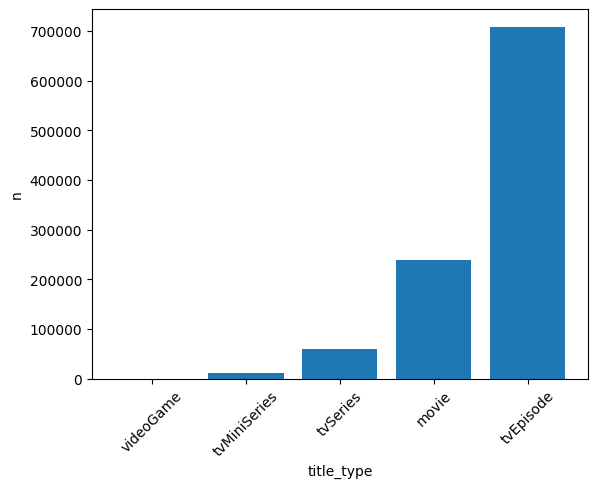

In [17]:
mtype = %sql SELECT title_type, count(title_type) AS n FROM Titles GROUP BY title_type ORDER BY n LIMIT 10
mtype.bar()

In [30]:
%%sql
select * from Title_ratings limit 10

 * mysql+mysqlconnector://root:***@db
10 rows affected.


title_id,average_rating,num_votes
tt0011216,6.9,30
tt0015724,6.2,25
tt0035423,6.4,82922
tt0059325,6.5,240
tt0059900,6.7,34
tt0062336,6.3,162
tt0063351,7.2,47
tt0065188,6.3,33
tt0067460,7.2,16
tt0068494,5.0,17


In [55]:
%%sql
describe Names_

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
name_id,b'varchar(255)',NO,,None,
name_,b'varchar(255)',NO,,None,
birth_year,b'smallint',YES,,None,
death_year,b'smallint',YES,,None,


#### 3 - Find the name and rating of the oldest videogame stored in the DB 

In [59]:
%%sql
SELECT *
FROM Titles TT
LEFT JOIN Title_ratings TR ON TT.title_id = TR.title_id
WHERE(TT.title_type = "videoGame")
ORDER BY (TT.start_year)
LIMIT 10

 * mysql+mysqlconnector://root:***@db
10 rows affected.


title_id,title_type,primary_title,start_year,runtime_minutes,title_id_1,average_rating,num_votes
tt0154789,videoGame,b'Lord of the Rings',1990,235,tt0154789,6.9,162
tt3326048,videoGame,b'Four Million Memories: The 1991 Toronto Blue Jays Highlight Video',1991,60,None,None,None
tt0296852,videoGame,b'The Simpsons',1991,58,tt0296852,8.4,674
tt6050814,videoGame,b'Pacific Islands',1992,46,None,None,None
tt14856064,videoGame,b'Rap Rat',1992,56,None,None,None
tt9698142,videoGame,b'Garth Brooks: We Shall Be Free',1992,4,None,None,None
tt5435234,videoGame,"b""Girl's Club""",1992,93,None,None,None
tt6066512,videoGame,b'B-17 Flying Fortress',1992,53,None,None,None
tt2912662,videoGame,b'BlaZeon',1992,38,None,None,None
tt2945568,videoGame,b'Shogun Warriors',1992,101,None,None,None


### Identify interesting outliers 

1. List the names of movies whose title begin with "The" have a runtime between 3 and 4 hours.
2. What actor had the most roles as 'Self'?
3. Identify what TV series had more than 1,000 episodes, and check the first- and last-episod year

#### 1 - List the names of movies whose title begin with "The" have a runtime between 3 and 4 hours.

In [16]:
%%sql
SELECT primary_title, runtime_minutes FROM Titles
WHERE(title_type = "movie") AND (primary_title like "The %") AND (runtime_minutes BETWEEN 3*60 AND 4*60) 
ORDER BY(runtime_minutes) DESC
LIMIT 10

 * mysql+mysqlconnector://root:***@db
10 rows affected.


primary_title,runtime_minutes
b'The Marvel Experience',240
b'The Way of Thorns',240
b'The British & Irish Lions: Uncovered',240
b'The Beautiful Troublemaker',238
b'The Story of Jonah and the Whale (Sort of...)',238
b'The Jim Breuer Road Journals',237
b'The Girl Who Picks Flowers and the Girl Who Kills Insects',236
b'The Hamburg Ballet John Neumeier - A Young Choreographers Evening 2021',235
b'The Uncertain Kingdom',235
b'The Future of Freedom: An Interview with NSA Whistleblower William Binney',235


#### 2 - What actor had the most roles as 'Self'?

In [43]:
%%sql
SELECT N.name_, count(N.name_) AS n, H.role_ FROM Names_ N
JOIN Had_role H ON H.name_id = N.name_id
WHERE(H.role_ = "Self")
GROUP BY(N.name_)
ORDER BY n DESC
LIMIT 10

 * mysql+mysqlconnector://root:***@db
10 rows affected.


name_,n,role_
Scott Morrison,3197,b'Self'
Tony Abbott,2763,b'Self'
Donald Trump,2210,b'Self'
John Howard,1162,b'Self'
Pauline Hanson,1099,b'Self'
Peter Dutton,1044,b'Self'
Barnaby Joyce,998,b'Self'
Paul Bowman,798,b'Self'
Arin Hanson,792,b'Self'
Brad Jones,751,b'Self'


#### 3 - Identify what TV series had more than 1,000 episodes, and check the first- and last-episod year

In [60]:
%%sql
DROP VIEW Serie

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [61]:
%%sql
CREATE VIEW Serie AS
SELECT parent_tv_show_title_id, count(episode_title_id) AS count, max(start_year) AS stop, min(start_year) AS start
FROM Episode_belongs_to E 
LEFT JOIN Titles T ON E.episode_title_id=T.title_id
GROUP BY parent_tv_show_title_id HAVING count > 1000
ORDER BY count DESC

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [66]:
%%sql
SELECT T.primary_title, S.count, S.start, S.stop
FROM Serie S
LEFT JOIN Titles T ON S.parent_tv_show_title_id=T.title_id
ORDER BY count DESC
LIMIT 10

 * mysql+mysqlconnector://root:***@db
10 rows affected.


primary_title,count,start,stop
b'Charlie Rose',9884,1992,2017
"b'Gute Zeiten, schlechte Zeiten'",7455,1992,2020
b'Judge Judy',7282,2014,2016
b'Unter uns',6803,1998,2012
b'Late Show with David Letterman',6691,1994,2015
"b'Goede tijden, slechte tijden'",6550,1990,2020
b'Young Hearts',6247,1996,2018
b'DAS!',5433,2007,2020
"b""L'invit\xc3\xa9""",5273,2007,2018
b'Volle Kanne',5111,None,None


In [63]:
%%sql
SELECT * FROM Serie
LIMIT 10

 * mysql+mysqlconnector://root:***@db
10 rows affected.


parent_tv_show_title_id,count,stop,start
tt0270116,9884,2017,1992
tt0103434,7455,2020,1992
tt0115227,7282,2016,2014
tt0108977,6803,2012,1998
tt0106053,6691,2015,1994
tt0096597,6550,2020,1990
tt0144724,6247,2018,1996
tt0289801,5433,2020,2007
tt4816922,5273,2018,2007
tt0498891,5111,None,None


In [56]:
%%sql
SELECT parent_tv_show_title_id, COUNT(episode_title_id) AS count
FROM Episode_belongs_to E
LEFT JOIN Titles T ON T.title_id=E.episode_title_id
GROUP BY parent_tv_show_title_id
HAVING count > 1000
ORDER BY count DESC
LIMIT 10;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


parent_tv_show_title_id,count
tt0270116,9884
tt0103434,7455
tt0115227,7282
tt0108977,6803
tt0106053,6691
tt0096597,6550
tt0144724,6247
tt0289801,5433
tt4816922,5273
tt0498891,5111


### It's all about the ratings 

1. Group all movies by decade and plot the rating distribution. Limit the query to the movies with at least 1000 ratings.
2. Plot the average rating of each episode of Games of Thrones. Group by season and compute the average and std for each season
3. Plot the total numer of movies per year, divided by genre (Action, Comedy, Drama, Thriller, Fantasy), and the yearly rating average per genre

#### 1 - Group all movies by decade and plot the rating distribution. Limit the query to the movies with at least 1000 ratings.

In [11]:
%%sql
USE IMDb;
SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
0 rows affected.
7 rows affected.


Tables_in_IMDb
Directors
Episode_belongs_to
Had_role
Names_
Title_genres
Title_ratings
Titles


#### 2 - Plot the average rating of each episode of Games of Thrones. Group by season and compute the average and std for each season

In [31]:
import numpy as np

res = %sql \
SELECT E.season_number, E.episode_number, R.average_rating \
FROM (Title_ratings R INNER JOIN Episode_belongs_to E ON E.episode_title_id = R.title_id) \
INNER JOIN Titles T ON E.parent_tv_show_title_id = T.title_id \
WHERE(primary_title = "Game of Thrones") \
ORDER BY E.season_number, E.episode_number;

 * mysql+mysqlconnector://root:***@db
73 rows affected.


1

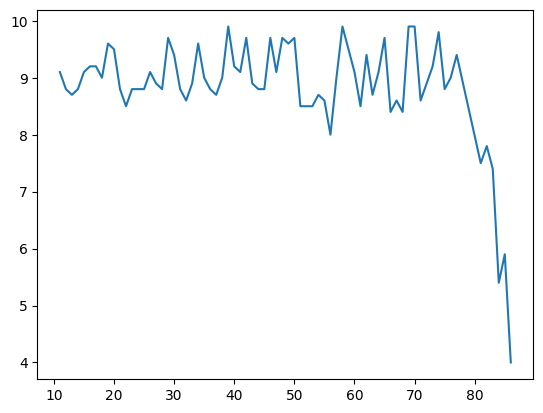

In [41]:
plt.plot(np.array(res)[:,0]*10+np.array(res)[:,1], np.array(res)[:,2])

In [61]:
%%sql

SELECT T.primary_title, E.season_number, E.episode_number, R.average_rating
FROM Episode_belongs_to E
INNER JOIN Titles T ON T.title_id = E.episode_title_id
INNER JOIN Title_ratings R ON R.title_id = E.episode_title_id
WHERE parent_tv_show_title_id = (
    SELECT title_id
    FROM Titles
    WHERE primary_title = 'Game of Thrones'
    AND title_type = 'tvSeries'
)
ORDER BY E.season_number, E.episode_number;

 * mysql+mysqlconnector://root:***@db
73 rows affected.


primary_title,season_number,episode_number,average_rating
b'Winter Is Coming',1,1,9.1
b'The Kingsroad',1,2,8.8
b'Lord Snow',1,3,8.7
"b'Cripples, Bastards, and Broken Things'",1,4,8.8
b'The Wolf and the Lion',1,5,9.1
b'A Golden Crown',1,6,9.2
b'You Win or You Die',1,7,9.2
b'The Pointy End',1,8,9.0
b'Baelor',1,9,9.6
b'Fire and Blood',1,10,9.5


#### 3 - Plot the total numer of movies per year, divided by genre (Action, Comedy, Drama, Thriller, Fantasy), and the yearly rating average per genre

In [74]:
res = %sql \
SELECT T.start_year, G.genre, AVG(R.average_rating) AS rating, STD(average_rating) AS std, count(*) AS count \
FROM Title_genres G \
INNER JOIN Title_ratings R ON G.title_id = R.title_id \
INNER JOIN Titles T ON G.title_id = T.title_id \
WHERE (T.title_type = "movie")  \
AND (T.start_year IS NOT NULL) \
AND (G.genre IN ("Action", "Comedy", "Drama", "Thriller", "Fantasy") ) \
GROUP BY T.start_year, G.genre \
ORDER BY T.start_year, G.genre


 * mysql+mysqlconnector://root:***@db
165 rows affected.


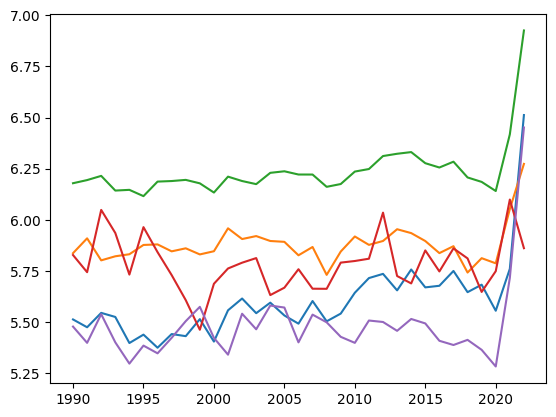

In [75]:
df = res.DataFrame()
for g in df.genre.unique():
    plt.plot(df[df.genre == g].start_year, df[df.genre == g].rating)